The Quest For A Better Network

In this assignment we will build a monster network to solve Tiny ImageNet image classification.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision, torchvision.transforms as transforms
from torch.autograd import Variable

from collections import defaultdict
from IPython.display import clear_output
import os
import pickle


In [ ]:
import tiny_img

In [ ]:
def fix_test_data(data_path, root='tiny-imagenet-200/val'):
    root = os.path.join(data_path, root)
    with open(os.path.join(root, 'val_annotations.txt')) as f:
        annotations = list(map(lambda x: x.split('\t')[0:2], f.readlines()))
        classes = sorted(set(map(lambda x: x[1], annotations)))
     
    try:
        for folder in classes:
            os.system('mkdir ' + os.path.join(root, folder))
            os.system('mkdir ' + os.path.join(root, folder, 'images'))

        for item in annotations:
            name, folder = item
            new_name = folder + '_' + name
            path, new_path = os.path.join(root, 'images', name), os.path.join(root, folder, 'images', new_name)
            os.system('cp ' + path + ' ' + new_path)
    
    except Exception as e:
        for folder in classes:
            os.system('rm ' + os.path.join(root, folder) + ' -rf')
        raise Exception('Something went wrong during copying val images. Check your access rights!')
            
    os.system('rm ' + os.path.join(root, 'images') + ' -rf')

In [ ]:
# downloading TinyImagenet
# you don't have to run this cell more than once

# from tiny_img import download_tinyImg200
# data_path = '.'
# download_tinyImg200(data_path)
# fix_test_data(data_path)

In [ ]:
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

./tiny-imagenet-200.zip


In [ ]:
!python3 '/content/fix_dataset.py' --dataset '/content/tiny-imagenet-200' --val-size 0.2

Copying train with splitting...
Train was copied successfully
Copying val...
Val was copied successfully
Fixed dataset was successfully created.


We will split `tiny-imagenet-200/train` dataset into train and val parts, and use  `tiny-imagenet-200/val` dataset as a test one

In [ ]:
import os
# imagenet_dir = os.path.join(data_path, 'tiny-imagenet-200')
# dataset = torchvision.datasets.ImageFolder(imagenet_dir + '/train', transform=transforms.ToTensor())
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000],
#                                                            generator=torch.Generator().manual_seed(42))
# test_dataset = torchvision.datasets.ImageFolder(imagenet_dir + '/val', transform=transforms.ToTensor())

# OR

# from tiny_img_ram import TinyImagenetRAM
# dataset = TinyImagenetRAM('tiny-imagenet-200/train', transform=transforms.ToTensor())
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000],
#                                                            generator=torch.Generator().manual_seed(42))
# test_dataset = TinyImagenetRAM('tiny-imagenet-200/val', transform=transforms.ToTensor())

In [ ]:
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomCrop(64, padding=4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder('/content/fixed-tiny-imagenet-200/train', transform=transform_train)
val_dataset = torchvision.datasets.ImageFolder('/content/fixed-tiny-imagenet-200/val', transform=transform_test)
test_dataset = torchvision.datasets.ImageFolder('/content/fixed-tiny-imagenet-200/test', transform=transform_test)

In [ ]:
batch_size = 50
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [ ]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

*We train our model with negative log-likelihood aka crossentropy.*

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.FloatTensor(X_batch).to(device=device)
    y_batch = torch.LongTensor(y_batch).to(device=device)
    logits = model.to(device)(X_batch)
    return F.cross_entropy(logits, y_batch).mean(), logits

def compute_mae(reference, prediction):
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
from torchsummary import summary

In [ ]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(3, 16, kernel_size=7, padding='same'))
model.add_module('bn1', nn.BatchNorm2d(16))
model.add_module('pool1', nn.MaxPool2d(kernel_size=3, stride=2))
model.add_module('relu1', nn.ReLU(inplace=True))

model.add_module('conv2', nn.Conv2d(16, 32, kernel_size=5, padding='same'))
model.add_module('bn2', nn.BatchNorm2d(32))
model.add_module('pool2', nn.MaxPool2d(kernel_size=3, stride=2))
model.add_module('relu2', nn.ReLU(inplace=True))

model.add_module('conv3', nn.Conv2d(32, 64, kernel_size=3, padding='same'))
model.add_module('bn3', nn.BatchNorm2d(64))
model.add_module('relu3', nn.ReLU(inplace=True))

# model.add_module('conv4', nn.Conv2d(384, 256, kernel_size=3, padding=1))
# model.add_module('bn4', nn.BatchNorm2d(256))
# model.add_module('relu4', nn.ReLU(inplace=True))

# model.add_module('conv5', nn.Conv2d(256, 256, kernel_size=3, padding=1))
# model.add_module('relu5', nn.ReLU(inplace=True))
# model.add_module('pool5', nn.MaxPool2d(kernel_size=2))

model.add_module('dropout1', nn.Dropout(0.4))

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(14400, 1024))
model.add_module('bn1_dense', nn.BatchNorm1d(1024))
model.add_module('relu1_dense', nn.ReLU(inplace=True))
model.add_module('dense2', nn.Linear(1024, 512))
model.add_module('dropout2', nn.Dropout(0.4))
model.add_module('relu2_dense', nn.ReLU(inplace=True))
model.add_module('dense3_logits', nn.Linear(512, 200)) # logits for 200 classes

summary(model.cuda(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]           2,368
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         MaxPool2d-3           [-1, 16, 31, 31]               0
              ReLU-4           [-1, 16, 31, 31]               0
            Conv2d-5           [-1, 32, 31, 31]          12,832
       BatchNorm2d-6           [-1, 32, 31, 31]              64
         MaxPool2d-7           [-1, 32, 15, 15]               0
              ReLU-8           [-1, 32, 15, 15]               0
            Conv2d-9           [-1, 64, 15, 15]          18,496
      BatchNorm2d-10           [-1, 64, 15, 15]             128
             ReLU-11           [-1, 64, 15, 15]               0
          Dropout-12           [-1, 64, 15, 15]               0
          Flatten-13                [-1, 14400]               0
           Linear-14                 [-

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
opt = torch.optim.Adam(model.parameters())

train_loss = []
val_accuracy = []
to_save = []

In [ ]:
print(model)

Sequential(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (dropout1): Dropout(p=0.6, inplace=False)
  (flatten): Flatten()
  (dense1): Linear(in_features=14400, out_features=1024, bias=True)
  (bn1_dense): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (

In [ ]:
def plot_learning_curves(history):
    """
    Function for model metrics plotting during training.

    :param history: (dict)
        accuracy и loss for train and validation.
    """
    plt.figure(figsize=(14, 6))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], color='r', label='train')
    plt.plot(history['val_loss'], color='b', label='val')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Loss')
    plt.ylim(0,5)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], color='r', label='train')
    plt.plot(history['val_acc'], color='b', label='val')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Accuracy')
    plt.ylim(0,55)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
train_loss_ = []
val_loss_ = []
train_accuracy = []
val_accuracy = []

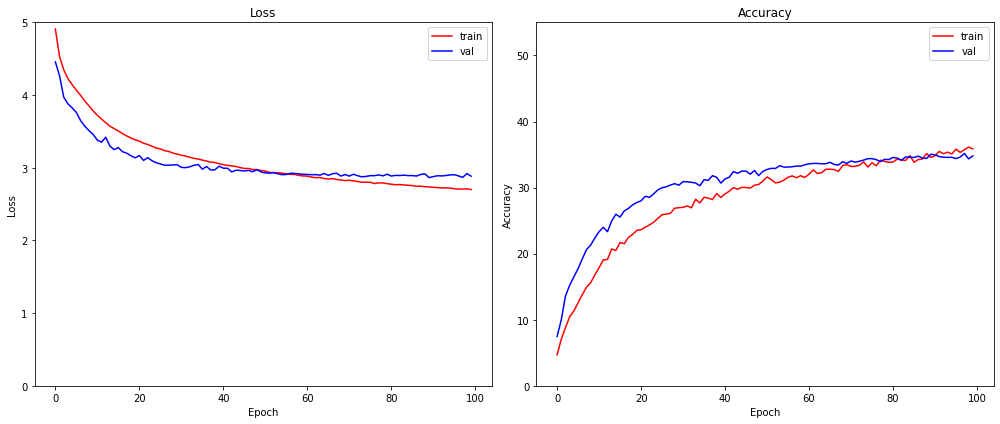

Epoch 100 of 100 took 65.487s
  training loss (in-iteration): 	2.699955
  validation loss (in-iteration): 	2.889877
  training accuracy: 			35.87 %
  validation accuracy: 			34.79 %


In [ ]:
import time
num_epochs = 100    # total amount of full passes over training data
batch_size = 50     # number of samples processed in one SGD iteration
save_iter_num = 5   # number of epoch for model saving

history = defaultdict(list)

for epoch in range(num_epochs):
    # print (num_epochs)
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    train_loss = train_mae = train_batches = 0
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        # loss = compute_loss(X_batch, y_batch)
        loss, logits = compute_loss(X_batch, y_batch)
        y_pred = logits.max(1)[1].data
        train_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss_.append(loss.data.cpu().numpy())

        train_loss += loss.item()
        train_batches += 1

    history['train_loss'].append(train_loss / train_batches)
    train_acc = np.mean(train_accuracy[-len(val_dataset) // batch_size :]) * 100
    history['train_acc'].append(train_acc)

    # print (num_epochs)    
    val_loss = val_mae = val_batches = 0
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        # logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
        loss, logits = compute_loss(X_batch, y_batch)
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
        val_loss_.append(loss.data.cpu().numpy())

        val_loss += loss.item()
        val_batches += 1

    history['val_loss'].append(val_loss / val_batches)
    val_acc = np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100
    history['val_acc'].append(val_acc)

    clear_output()

    plot_learning_curves(history)

    # print (num_epochs)
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss_[-len(train_dataset) // batch_size :])))
    print("  validation loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss_[-len(train_dataset) // batch_size :])))
    print("  training accuracy: \t\t\t{:.2f} %".format(
        train_acc))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        val_acc))
    
    if epoch % save_iter_num == 0:
        file_path = f'/content/val_accuracy'
        with open(file_path, 'wb') as f:
            pickle.dump(history['val_acc'], f)
    if val_acc == np.max(history['val_acc']):
        file_path = '/content/best_model'
        torch.save(model.state_dict(), file_path)

When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [ ]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             num_workers=1)

In [ ]:
test_acc = []
for X_batch, y_batch in test_batch_gen:
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data
    test_acc.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

test_accuracy = np.mean(test_acc)

In [ ]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		35.99 %
Achievement unlocked: 80lvl Warlock!


Исходно была взята модель с третьего семинара, способ обучения в том числе. Она давала что-то далекое от желаемого значения accuracy, поэтому далее было решено оставить ее подобие, как основу (скорее даже как финальную часть модели), а на старте наращивать количество слоев и их сложность.

Здесь по большей части вдохновлялся архитектурой `AlexNet` — отдал предпочтение функции активации `ReLU`, добавил еще `Dropout` (из-за чего обучение замедлилось), не забыл про `MaxPool` и `Conv2d`. С дропаутом "игрался" долго — итерации три понадобилось, чтобы подобрать параметры, избавляющие от переобучения и не дающие недообучение.

Параллельно с этим добавил аугментаций — рандомных поворотов/кропов для `train`-части, а также нормализацию. Последний этап дал заметный прирост в точности. (Его отслеживал отдельно)

Увеличивал/уменьшал количество слоев, по итогу структура попроще и с меньшим количеством каналов показала себя лучше.

* Accuracy на трейне: 35.87 %
* Accuracy на валидации: 34.79 %
* Accuracy на тесте: 35.99 %